In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier, DMatrix
from sklearn.model_selection import train_test_split
from sklearn import metrics
import _pickle as pickle
import seaborn as sns


In [56]:
raw_df = pd.read_csv("processed_data/tfidf_df.csv")
vectorizer = pickle.load(open("processed_data/tfidf_vectorizer.pkl", "rb"))


In [57]:
## https://stackoverflow.com/questions/44114463/stratified-sampling-in-pandas
def stratified_sample_df(df, col, n_samples, random_state=69):
    n = min(n_samples, df[col].value_counts().min())
    df_ = df.groupby(col).apply(lambda x: x.sample(n, random_state=random_state))
    df_.index = df_.index.droplevel(0)
    return df_


In [121]:
df = stratified_sample_df(raw_df, "topic_area", 50, random_state=69)

y_map = {k: i for i, k in enumerate(df.topic_area.unique())}
df.topic_area = df.topic_area.apply(lambda x: y_map[x])


In [122]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=69
)


In [123]:
model = XGBClassifier(
    objective="multi:softmax",
    colsample_bytree=0.6,
    subsample=0.7,
    random_state=69,
    max_depth=4,
    eval_metric="merror",
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)


/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [124]:
pickle.dump(model, open("saved_models/tfidf_model.pkl", "wb"))


In [125]:
accuracy = metrics.accuracy_score(y_test, y_pred)
roc = metrics.roc_auc_score(y_test, y_pred_prob, multi_class="ovr")
class_report = metrics.classification_report(y_test, y_pred)
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)


# Visualisations

In [126]:
print(class_report)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        10
           3       1.00      0.80      0.89        10
           4       0.83      1.00      0.91        10
           5       1.00      1.00      1.00        10
           6       1.00      1.00      1.00        10

    accuracy                           0.97        70
   macro avg       0.98      0.97      0.97        70
weighted avg       0.98      0.97      0.97        70



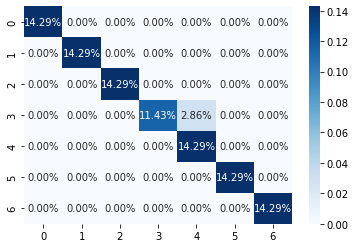

In [127]:
## Confusion Matrix
sns.heatmap(
    confusion_matrix / np.sum(confusion_matrix), fmt=".2%", annot=True, cmap="Blues"
)
plt.show()


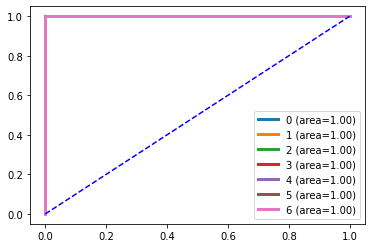

In [128]:
## https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
classes = y.unique()
y_test_array = pd.get_dummies(y_test, drop_first=False).values
fig, ax = plt.subplots()
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:, i], y_pred_prob[:, i])
    ax.plot(
        fpr,
        tpr,
        lw=3,
        label="{0} (area={1:0.2f})".format(classes[i], metrics.auc(fpr, tpr)),
    )
ax.plot([0, 1], [0, 1], color="blue", linestyle="--")
ax.legend()


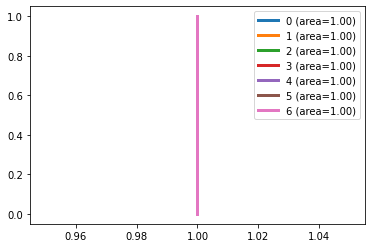

In [129]:
classes = y.unique()
y_test_array = pd.get_dummies(y_test, drop_first=False).values
fig, ax = plt.subplots()
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
        y_test_array[:, i], y_pred_prob[:, i]
    )
    ax.plot(
        precision,
        recall,
        lw=3,
        label="{0} (area={1:0.2f})".format(classes[i], metrics.auc(recall, precision)),
    )
ax.legend()
